## Automatic Feature Selection

With so many ways to create new features, you might get tempted to increase the dimensionality of the data way beyond the number of original features. However, adding more features makes all models more complex, and so increases the chance of overfitting. When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. This can lead to simpler models that generalize better. 

But how can you know how good each feature is? There are three basic strategies: *univariate statistics*, *model-based selection*, and *iterative selection*. We will discuss all three of them in detail. All of these methods are supervised methods, meaning they need the target for fitting the model. This means we need to split the data into training and test sets, and fit the feature selection only on the training part of the data.

### Univariate Statistics

In univariate statistics, we compute whether there is a statistically significant relationship between each feature and the target. Then the features that are related with the highest confidence are selected. In the case of classification, this is also known as *analysis of variance (ANOVA)*. 

A key property of these tests is that they are *univariate*, meaning that they only consider each feature individually. Consequently, a feature will be discarded if it is only informative when combined with another feature. Univariate tests are often very fast to compute, and don’t require building a model. On the other hand, they are completely independent of the model that you might want to apply after the feature selection.

To use univariate feature selection in scikit-learn, you need to choose a test, usually either *f_classif* (the default) for classification or f_regression for regression, and a method to discard features based on the *p-values* determined in the test. All methods for discarding parameters use a threshold to discard all features with too high a p-value (which means they are unlikely to be related to the target). 

The methods differ in how they compute this threshold, with the simplest ones being *SelectKBest*, which selects a fixed number k of features, and *SelectPercentile*, which selects a fixed percentage of features. 

Let’s apply the feature selection for classification on the *cancer* dataset. To make the task a bit harder, we’ll add some noninformative noise features to the data. We expect the feature selection to be able to identify the features that are noninformative and remove them:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# Get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# Add noise features to the data
# The first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

# Use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# Transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


As you can see, the number of features was reduced from 80 to 40 (50 percent of the original number of features). We can find out which features have been selected using the *get_support* method, which returns a Boolean mask of the selected features:

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([], <a list of 0 Text yticklabel objects>)

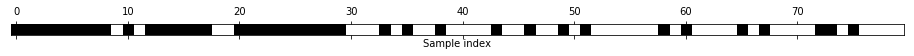

In [3]:
mask = select.get_support()
print(mask)

# Visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

As you can see from the visualization of the mask, most of the selected features are the original features, and most of the noise features were removed. However, the recovery of the original features is not perfect. Let’s compare the performance of logistic regression on all features against the performance using only the selected features:

In [4]:
from sklearn.linear_model import LogisticRegression

# Transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression()

lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


In this case, removing the noise features improved performance, even though some of the original features were lost. This was a very simple synthetic example, and outcomes on real data are usually mixed. Univariate feature selection can still be very helpful, though, if there is such a large number of features that building a model on them is infeasible, or if you suspect that many features are completely uninformative.

### Model-Based Feature Selection

Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling. The feature selection model needs to provide some measure of importance for each feature, so that they can be ranked by this measure. 

Decision trees and decision tree–based models provide a *feature_importances_* attribute, which directly encodes the importance of each feature. Linear models have coefficients, which can also be used to capture feature importances by considering the absolute values. As we saw in Chapter 2, linear models with L1 penalty learn sparse coefficients, which only use a small subset of features. This can be viewed as a form of feature selection for the model itself, but can also be used as a preprocessing step to select features for another model. In contrast to univariate selection, model-based selection considers all features at once, and so can capture interactions (if the model can capture them). 

To use model-based feature selection, we need to use the *SelectFromModel* transformer:

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

The *SelectFromModel* class selects all features that have an importance measure of the feature (as provided by the supervised model) greater than the provided threshold. To get a comparable result to what we got with univariate feature selection, we used the median as a threshold, so that half of the features will be selected. We use a random forest classifier with 100 trees to compute the feature importances. This is a quite complex model and much more powerful than using univariate tests. 

Now let’s actually fit the model:

In [7]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Again, we can have a look at the features that were selected:

([], <a list of 0 Text yticklabel objects>)

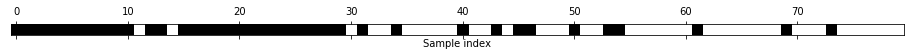

In [8]:
mask = select.get_support()

# Visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

This time, all but two of the original features were selected. Because we specified to select 40 features, some of the noise features are also selected. 

Let’s take a look at the performance:

In [10]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)

print("Test score: {:.3f}".format(score))

Test score: 0.951


With the better feature selection, we also gained some improvements here.